In [ ]:
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
import wandb

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
# Auxiliary visualization and evaluation functions (see helper.py in the repo)

# from torch.autograd import Variable
# def test_network(net, trainloader):

#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(net.parameters(), lr=0.001)

#     dataiter = iter(trainloader)
#     images, labels = dataiter.next()

#     # Create Variables for the inputs and targets
#     inputs = Variable(images)
#     targets = Variable(images)

#     # Clear the gradients from all Variables
#     optimizer.zero_grad()

#     # Forward pass, then backward pass, then update weights
#     output = net.forward(inputs)
#     loss = criterion(output, targets)
#     loss.backward()
#     optimizer.step()

#     return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


# def view_recon(img, recon):
#     ''' Function for displaying an image (as a PyTorch Tensor) and its
#         reconstruction also a PyTorch Tensor
#     '''

#     fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
#     axes[0].imshow(img.numpy().squeeze())
#     axes[1].imshow(recon.data.numpy().squeeze())
#     for ax in axes:
#         ax.axis('off')
#         ax.set_adjustable('box-forced')

# def view_classify(img, ps, version="MNIST"):
#     ''' Function for viewing an image and it's predicted classes.
#     '''
#     ps = ps.data.numpy().squeeze()

#     fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
#     ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
#     ax1.axis('off')
#     ax2.barh(np.arange(10), ps)
#     ax2.set_aspect(0.1)
#     ax2.set_yticks(np.arange(10))
#     if version == "MNIST":
#         ax2.set_yticklabels(np.arange(10))
#     elif version == "Fashion":
#         ax2.set_yticklabels(['T-shirt/top',
#                             'Trouser',
#                             'Pullover',
#                             'Dress',
#                             'Coat',
#                             'Sandal',
#                             'Shirt',
#                             'Sneaker',
#                             'Bag',
#                             'Ankle Boot'], size='small');
#     ax2.set_title('Class Probability')
#     ax2.set_xlim(0, 1.1)

#     plt.tight_layout()


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from pathlib import Path
data_dir = Path('/gdrive/MyDrive/final_project_first_images')

# see if folder is available in this path -> "Verknüpfung" erforderlich bei geteiltten ordnern
import os
tmp_folder_path = '/gdrive/MyDrive'
folders = os.listdir(tmp_folder_path)
print(folders)


['2019Abrechnung_Sebastian_Edith.xlsx', 'Umzugsliste.xlsx', 'WhatsApp', 'Colab Notebooks', 'Crypto Forecasting.gslides', 'Cat_Dog_data', 'cobblestones_012.jpg', 'final_project_first_images', 'pets_images', 'pets_images_2', 'camvid_normal', 'camvid_tiny', 'dogs_vs_cats', 'art_recommendation', 'banksy_2.jpg']


In [ ]:
# WandB – Initialize a new run
wandb.init(project="berlin_bike_cv") # name= ??

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = 48          # input batch size for training (default: 64)
config.test_batch_size = 48    # input batch size for testing (default: 1000)
config.epochs = 10             # number of epochs to train (default: 10)
config.lr = 0.003               # learning rate (default: 0.01)
# config.momentum = 0.1          # SGD momentum (default: 0.5)
# config.no_cuda = False         # disables CUDA training
config.seed = 42               # random seed (default: 42)
# config.log_interval = 10     # how many batches to wait before logging training status
# augmentation parameters?
config.image_height = 768
config.image_width = 1_024

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [ ]:
# ### Augmentation, from https://pytorch.org/vision/stable/transforms.html
# # examples: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
# # no v2 methods

# # Geometry
# Resize(size[, interpolation, max_size, ...]) # Resize the input image to the given size
# # RandomCrop(size[, padding, pad_if_needed, ...]) # Crop the given image at a random location
# # RandomResizedCrop(size[, scale, ratio, ...]) # Crop a random portion of image and resize it to a given size
# # CenterCrop(size) # Crops the given image at the center. FiveCrop, TenCrop..
# # Pad(padding[, fill, padding_mode]) # Pad the given image on all sides with the given "pad" value
# RandomRotation(degrees[, interpolation, ...]) # Rotate the image by angle
# # RandomAffine(degrees[, translate, scale, ...]) # Random affine transformation of the image keeping center invariant = rotate, scale, translate
# RandomPerspective([distortion_scale, p, ...]) # Performs a random perspective transformation of the given image with a given probability
# # ElasticTransform([alpha, sigma, ...]) # Transform a tensor image with elastic transformations (produces a see-through-water-like effect)
# RandomHorizontalFlip([p]) # Horizontally flip the given image randomly with a given probability
# RandomVerticalFlip([p]) # Vertically flip the given image randomly with a given probability

# # Color
# ColorJitter([brightness, contrast, ...]) # Randomly change the brightness, contrast, saturation and hue of an image
# # Grayscale([num_output_channels]) # Convert image to grayscale
# # RandomGrayscale([p]) # Randomly convert image to grayscale with a probability of p (default 0.1)
# GaussianBlur(kernel_size[, sigma]) # Blurs image with randomly chosen Gaussian blur
# # RandomInvert([p]) # Inverts the colors of the given image randomly with a given probability
# # RandomPosterize(bits[, p]) # Posterize the image randomly with a given probability by reducing the number of bits for each color channel.
# # RandomSolarize(threshold[, p]) # Solarize the image randomly with a given probability by inverting all pixel values above a threshold
# RandomAdjustSharpness(sharpness_factor[, p]) # Adjust the sharpness of the image randomly with a given probability
# RandomAutocontrast([p]) # Autocontrast the pixels of the given image randomly with a given probability
# # RandomEqualize([p])# Equalize the histogram of the given image randomly with a given probability

# # Composition
# # apply transformation by a specific rule

# # Miscellaneous
# Normalize(mean, std[, inplace]) # Normalize a tensor image with mean and standard deviation
# RandomErasing([p, scale, ratio, value, inplace]) # Randomly selects a rectangle region in a torch.Tensor image and erases its pixels
# Lambda(lambd) # Apply a user-defined lambda as a transform

# # Auto-Augmentation
# # common Data Augmentation technique that can improve the accuracy of Image Classification models.
# # Though the data augmentation policies are directly linked to their trained dataset,
# # empirical studies show that ImageNet policies provide significant improvements when applied to other datasets.
# # In TorchVision we implemented 3 policies learned on the following datasets: ImageNet, CIFAR10 and SVHN.
# # The new transform can be used standalone or mixed-and-matched with existing transforms
# AutoAugmentPolicy(value) # AutoAugment policies learned on different datasets
# AutoAugment([policy, interpolation, fill]) # AutoAugment data augmentation method based on "AutoAugment: Learning Augmentation Strategies from Data"
# RandAugment([num_ops, magnitude, ...]) # RandAugment data augmentation method based on "RandAugment: Practical automated data augmentation with a reduced search space"
# TrivialAugmentWide([num_magnitude_bins, ...]) # Dataset-independent data-augmentation with TrivialAugment Wide, as described in "TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation"
# AugMix([severity, mixture_width, ...]) # AugMix data augmentation method based on "AugMix: A Simple Data Processing Method to Improve Robustness and Uncertainty"



In [ ]:
from PIL import Image, ImageMath

class MaskedDataset(datasets.ImageFolder):
    # use "train", "test", "mask" folder inside root_dir
    # mask is a segmentation mask with bikelane = 7
    # alpha defines how intensive the background should be: 1=original, 0=no background
    def __init__(
        self,
        root_dir,
        image_sub_dir,
        mask_sub_dir="mask",
        alpha=0.5,
        reduced_channel=True,
        transform=None,
    ):
        super().__init__(root=os.path.join(root_dir, image_sub_dir))
        self.mask_dir = os.path.join(root_dir, mask_sub_dir)
        self.alpha = alpha
        self.transform = transform
        self.reduced_channel = reduced_channel

    def __getitem__(self, index):
        img_path, label = self.imgs[index]
        img_base_name = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = os.path.join(self.mask_dir, img_base_name + "_mask.png")
        image = Image.open(img_path)
        image = image.convert("RGBA")
        mask = Image.open(mask_path)
        # transform to array, PIL Image cannot be used to compare to 7 = bikelane
        mask = np.array(mask)
        blend_mask = np.ones_like(mask, dtype="float32") * 255
        blend_mask[mask != 7] *= self.alpha
        alpha_image = Image.fromarray(blend_mask.astype(np.uint8), mode="L")
        image.putalpha(alpha_image)

        # squeeze to 3-Channel image again
        if self.reduced_channel:
            r, g, b, a = image.split()
            # Multiplizieren der RGB-Kanäle mit dem Alpha-Kanal
            r = ImageMath.eval("convert(r * a / 255, 'L')", r=r, a=a)
            g = ImageMath.eval("convert(g * a / 255, 'L')", g=g, a=a)
            b = ImageMath.eval("convert(b * a / 255, 'L')", b=b, a=a)
            # Zusammenführen der Kanäle zu einem neuen Bild im RGB-Format
            image = Image.merge("RGB", (r, g, b))

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       #transforms.RandomResizedCrop(224),  #  not that useful to crop random pixels?? which size?
                                       transforms.Resize((config.image_height, config.image_width)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.Resize((config.image_height, config.image_width)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = MaskedDataset(data_dir, 'train', 'mask', alpha=0.5,
        reduced_channel=False, transform=train_transforms)
test_data = MaskedDataset(data_dir, 'test', 'mask', alpha=0.5,
        reduced_channel=False, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=config.test_batch_size)

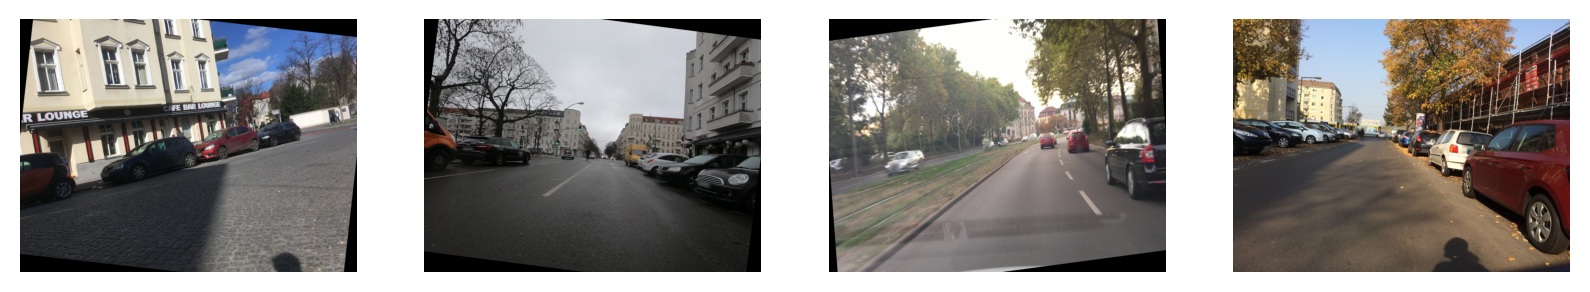

In [ ]:
# Run this to test your data loader
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)

In [58]:
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [33]:
model.features[0][0]

Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [ ]:
model.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [59]:
in_weight = model.features[0][0].weight.clone()
print(in_weight)

tensor([[[[-5.4401e-01, -3.7206e-02,  6.3111e-01],
          [-1.0392e+00, -1.3085e-01,  1.2488e+00],
          [-1.0812e+00, -1.8459e-01,  1.1340e+00]],

         [[-8.5868e-01, -1.1450e-01,  8.6298e-01],
          [-1.4365e+00, -1.9233e-01,  1.6726e+00],
          [-1.4089e+00, -1.5873e-01,  1.6051e+00]],

         [[-2.8959e-01, -5.9951e-02,  3.3583e-01],
          [-6.4620e-01, -3.3095e-02,  9.3563e-01],
          [-7.2531e-01, -2.2003e-01,  7.5415e-01]]],


        [[[ 9.2411e-02,  8.2445e-02, -8.0609e-02],
          [ 1.7470e-01, -3.9439e-02, -1.4034e-01],
          [ 1.1751e-01, -3.8109e-02, -1.8781e-01]],

         [[-2.5695e-02, -3.3787e-01, -2.9581e-01],
          [-3.5672e-01, -7.0179e-01, -5.3996e-01],
          [-2.6703e-01, -5.0035e-01, -4.9675e-01]],

         [[-3.4249e-03,  2.7593e-01,  3.0237e-01],
          [ 1.5845e-01,  8.0262e-01,  8.4072e-01],
          [ 3.9735e-02,  6.6918e-01,  6.2176e-01]]],


        [[[-5.6148e-02, -7.4883e-02, -5.0135e-02],
          [-9.3

In [60]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [61]:
in_weight = model.features[0][0].weight.clone()
model.features[0][0] = nn.Conv2d(4, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

with torch.no_grad():
    model.features[0][0].weight[:, :3] = in_weight

In [63]:
# Freeze new parameters
weights_slice = model.features[0][0].weight[:, :3].detach()
weights_slice.requires_grad = False

# Erstellen eines neuen Tensors mit den aktualisierten Werten
print(weights_slice.shape)
print(model.features[0][0].weight[:, 3:, :, :].shape)
updated_weights_slice = torch.cat([weights_slice, model.features[0][0].weight[:, 3:, :, :]], dim=1)

# Setzen des modifizierten Tensor-Slices zurück in das Modell
model.features[0][0].weight = torch.nn.Parameter(updated_weights_slice)

torch.Size([24, 3, 3, 3])
torch.Size([24, 3, 3])


In [64]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

864

In [15]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(4, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [24]:
sum(p.numel() for p in model.features[0][0].parameters() if p.requires_grad==False)
print(model.features[0][0].weight)

Parameter containing:
tensor([[[[-5.4401e-01, -3.7206e-02,  6.3111e-01],
          [-1.0392e+00, -1.3085e-01,  1.2488e+00],
          [-1.0812e+00, -1.8459e-01,  1.1340e+00]],

         [[-8.5868e-01, -1.1450e-01,  8.6298e-01],
          [-1.4365e+00, -1.9233e-01,  1.6726e+00],
          [-1.4089e+00, -1.5873e-01,  1.6051e+00]],

         [[-2.8959e-01, -5.9951e-02,  3.3583e-01],
          [-6.4620e-01, -3.3095e-02,  9.3563e-01],
          [-7.2531e-01, -2.2003e-01,  7.5415e-01]],

         [[ 1.6334e-01,  5.3788e-02,  2.7384e-02],
          [-8.8838e-02, -1.0567e-01,  4.8039e-02],
          [-7.9312e-02, -1.1093e-01,  5.1718e-02]]],


        [[[ 9.2411e-02,  8.2445e-02, -8.0609e-02],
          [ 1.7470e-01, -3.9439e-02, -1.4034e-01],
          [ 1.1751e-01, -3.8109e-02, -1.8781e-01]],

         [[-2.5695e-02, -3.3787e-01, -2.9581e-01],
          [-3.5672e-01, -7.0179e-01, -5.3996e-01],
          [-2.6703e-01, -5.0035e-01, -4.9675e-01]],

         [[-3.4249e-03,  2.7593e-01,  3.0237e-

In [ ]:
from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1280, 256)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(256, 1)),
    ('output', nn.Sigmoid())
    ]))

model.classifier[1] = fc

In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier[1].parameters(), lr=config.lr)

model.to(device);

In [ ]:
# WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
# Using log="all" log histograms of parameter values in addition to gradients
wandb.watch(model, log="all")

[]

In [ ]:
torch.manual_seed(config.seed) # pytorch random seed


train_loss_list = []
test_loss_list = []
accuracy_list = []
for epoch in range(config.epochs):
    running_loss = 0
    test_loss = 0
    accuracy = 0
    example_images = []

    for inputs, labels in trainloader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        labels = torch.unsqueeze(labels, 1)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    with torch.no_grad():
        model.eval()
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32)
            logps = model.forward(inputs)
            labels = torch.unsqueeze(labels, 1)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate accuracy
            # ps = torch.exp(logps)
            # top_p, top_class = ps.topk(1, dim=1)
            # equals = top_class == labels.view(*top_class.shape)
            binary_predictions = (logps > 0.5).float()
            equals = binary_predictions == labels
            acc =  torch.mean(equals.type(torch.FloatTensor)).item()
            accuracy += acc
            # WandB – Log images (first per test batch) in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
            example_images.append(wandb.Image(
                inputs[0], caption="Pred: {} Truth: {}".format(labels[0], logps[0]))) # logps is not the right value, image is always the same -> use random and more images?

    model.train()

    train_loss_list.append(running_loss/len(trainloader))
    test_loss_list.append(test_loss/len(testloader))
    accuracy_list.append(accuracy/len(testloader))


    print(f"Epoch {epoch+1}/{config.epochs}.. ",
          f"Train loss: {train_loss_list[-1]:.3f}.. ",
          f"Test loss: {test_loss_list[-1]:.3f}.. ",
          f"Test accuracy: {accuracy_list[-1]:.3f}",)

    # WandB – wandb.log(a_dict) logs the keys and values of the dictionary passed in and associates the values with a step.
    # You can log anything by passing it to wandb.log, including histograms, custom matplotlib objects, images, video, text, tables, html, pointclouds and other 3D objects.
    # Here we use it to log test accuracy, loss and some test images (along with their true and predicted labels).
    wandb.log({
        "Examples": example_images,
        "Test Accuracy": accuracy_list[-1],
        "Test Loss": test_loss_list[-1]})


Epoch 1/10..  Train loss: 0.671..  Test loss: 0.485..  Test accuracy: 0.775
Epoch 2/10..  Train loss: 0.493..  Test loss: 0.289..  Test accuracy: 0.925
Epoch 3/10..  Train loss: 0.378..  Test loss: 0.260..  Test accuracy: 0.875
Epoch 4/10..  Train loss: 0.254..  Test loss: 0.155..  Test accuracy: 0.950
Epoch 5/10..  Train loss: 0.262..  Test loss: 0.194..  Test accuracy: 0.925
Epoch 6/10..  Train loss: 0.147..  Test loss: 0.108..  Test accuracy: 0.975
Epoch 7/10..  Train loss: 0.165..  Test loss: 0.101..  Test accuracy: 0.975
Epoch 8/10..  Train loss: 0.131..  Test loss: 0.105..  Test accuracy: 0.975
Epoch 9/10..  Train loss: 0.133..  Test loss: 0.102..  Test accuracy: 0.950
Epoch 10/10..  Train loss: 0.077..  Test loss: 0.120..  Test accuracy: 0.950


In [ ]:
# WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.
torch.save(model.state_dict(), "efficient_net.pt") # ???
wandb.save('efficient_net.pt')

wandb.unwatch()

# add a timestemp to the model?

In [ ]:
# save model
import joblib

joblib.dump(model, "cobblestones_efficientnet.pkl")

['cobblestones_efficientnet.pkl']

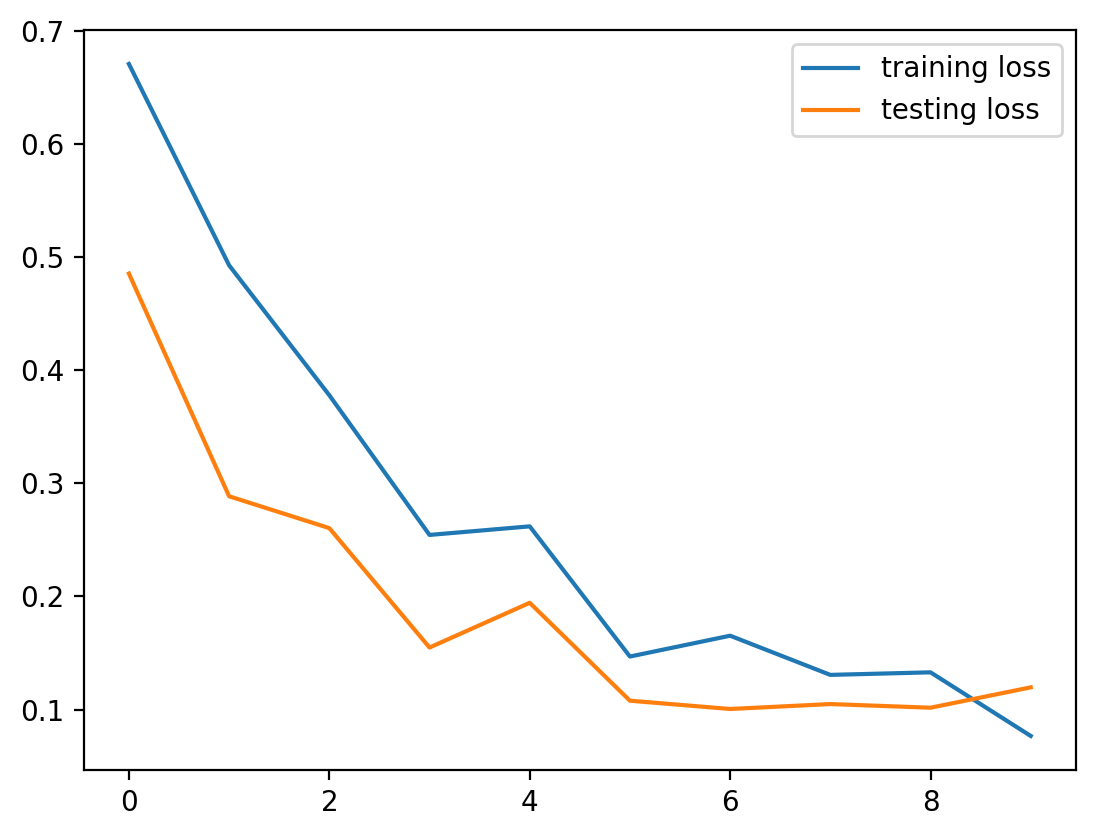

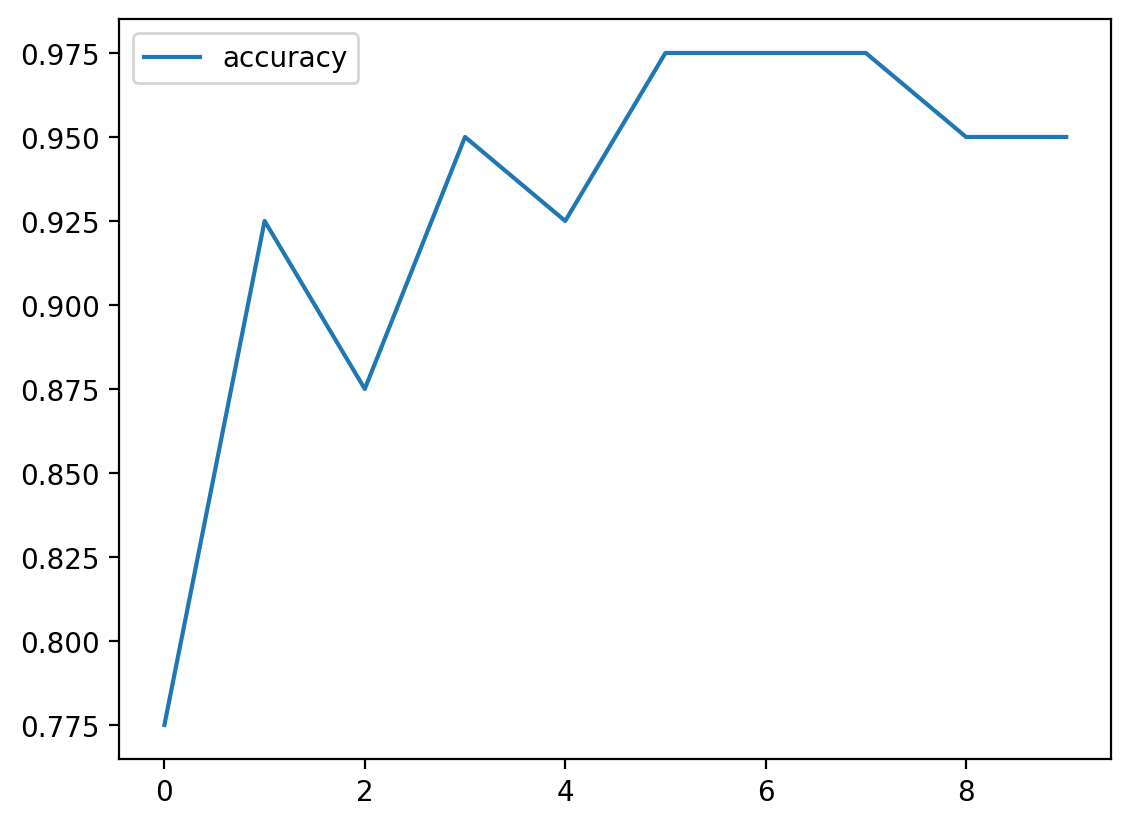

In [ ]:
# plot performance
def plot_training(train_loss_list, test_loss_list, accuracy_list):
  plt.plot(train_loss_list,label='training loss')
  plt.plot(test_loss_list,label='testing loss')
  plt.legend()
  plt.show()
  plt.plot(accuracy_list,label='accuracy')
  plt.legend()
  plt.show()

plot_training(train_loss_list, test_loss_list, accuracy_list)